In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:
import os
import sys

try:
    from fluidity_tools import stat_parser as stat
except ImportError:
    # try again by adding the path "../python" relative to testharness' own location to sys.path
    head, tail = os.path.split(sys.argv[0])
    # python_path = os.path.abspath(os.path.join(head, '..', 'python'))
    sys.path.append('/home/gn/Code/fetch2012/fluidity/python')
    from fluidity_tools import stat_parser as stat

import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D
from matplotlib2tikz import save as tikz_save
# %matplotlib   #todo: uncomment if you want plots to pop
# plt.rcParams["font.family"] = "Times New Roman"
# Make background white
plt.style.use('default')


/home/gn/anaconda3/lib/python3.7/site-packages/matplotlib2tikz/__init__.py:31: UserWarning: matplotlib2tikz has been renamed to tikzplotlib (which is Python-3-only). matplotlib2tikz will no longer be supported.
  warnings.warn("matplotlib2tikz has been renamed to tikzplotlib (which is Python-3-only). matplotlib2tikz will no longer be supported.")


In [2]:
DIR = '/home/gn/Code/Archer/tests/dogleg'
STAT_F = 'rad_dogleg_noio.Neutron.output_quantities.stat'
CORES = [48, 96, 192, 240, 384, 480]
lb_time = {}
wall_time = {}
cdofs = {}
HALOS = {}
NODES = {}
AV = {}
MIN = {}
MAX = {}

def av_min_max_halos(prefix, cores, max_adapt_step):
    """
    I could do a better job algorithmically but this is fine for now.
    Returns the average number of nodes owned, halo 1s, 
    the minimum number of nodes owned at every adapt step, with its halo size,
    the max number of halo nodes at every adapt step, with its nodes owned size.
    It also returns the original node and halo 2d arrays
    """
    nodes = np.ndarray(shape=(cores, max_adapt_step))
    halos = np.ndarray(shape=(cores, max_adapt_step))

    # Run through all the partitions and get the number of nodes owned and the number of nodes in the halo 1
    for i in range(cores):
        nodes[i], halos[i] = np.loadtxt(f'{prefix}.log_{i}', usecols=(1, 3), unpack=True)
    
    av_nodes = np.mean(nodes, axis=0)
    av_halos = np.mean(halos, axis=0)
    
    min_nodes = np.min(nodes, axis=0)
    # Get the index where the min nodes occurred
    min_halos = halos[np.argmin(nodes, axis=0), [i for i in range(max_adapt_step)]]
    
    max_halos = np.max(halos, axis=0)
    max_nodes = nodes[np.argmax(halos, axis=0), [i for i in range(max_adapt_step)]]
    
    average = [av_nodes, av_halos]
    min_data = [min_nodes, min_halos]
    max_data = [max_nodes, max_halos]
    
    return average, min_data, max_data, nodes, halos

def strong_scaling(t0, c0, tn, cn):
    """
        Takes the time and number of cores for 2 simulations and returns 
    """
    return t0 / (cn/c0 * tn) * 100


In [3]:

for cpu in CORES:
    os.chdir(f'{DIR}/core{cpu}')
    lb_time[cpu] = stat(STAT_F)['RadiantLoadBalanceTime']['Value']
    wall_time[cpu] = stat(STAT_F)['ElapsedWallTime']['Value']
    cdofs[cpu] = stat(STAT_F)['ContinuousDOF_per_group']['Value']
    AV[cpu], MIN[cpu], MAX[cpu], NODES[cpu], HALOS[cpu] = av_min_max_halos('rad_dogleg_noio', cpu, 5) 

os.chdir('/home/gn/Dropbox/PhD/ANSWERS_seminar2019/2019/figures')


 # LB Time vs CDOF for all cores

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


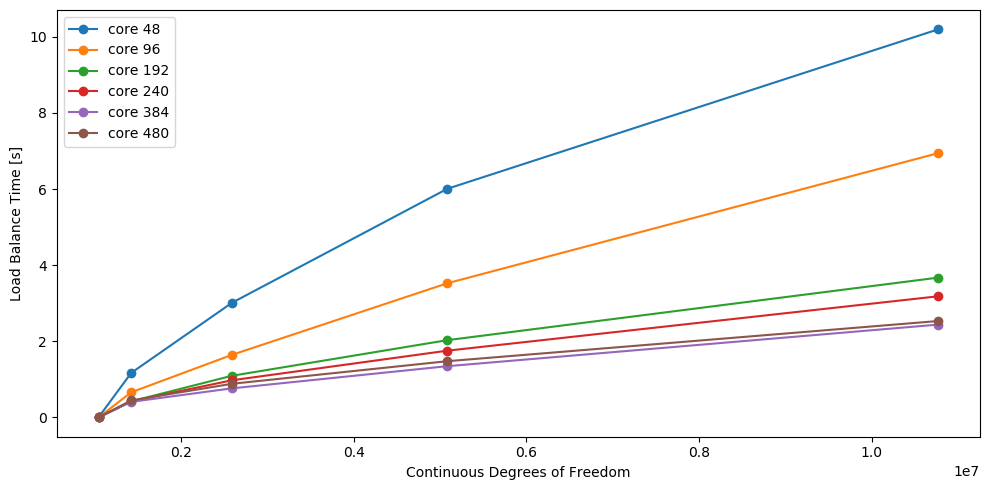

In [4]:
fname='LB_time_vs_CDOF.png'
fig, ax = plt.subplots(figsize=(10,5))
fig.canvas.set_window_title(fname)
for cpu in CORES:
    ax.plot(cdofs[cpu], lb_time[cpu], 
            marker='o', 
            label=f'core {cpu}')
ax.legend()
ax.set(xlabel='Continuous Degrees of Freedom', ylabel='Load Balance Time [s]')
fig.tight_layout()
# fig.savefig(fname)
fig.show()


 # STRONG SCALING

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/gn/anaconda3/lib/python3.7/site-packages/matplotlib2tikz/axes.py:508: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.get_visible instead.
  major_ticks_bottom = [tick.tick1On for tick in major_ticks]
/home/gn/anaconda3/lib/python3.7/site-packages/matplotlib2tikz/axes.py:50

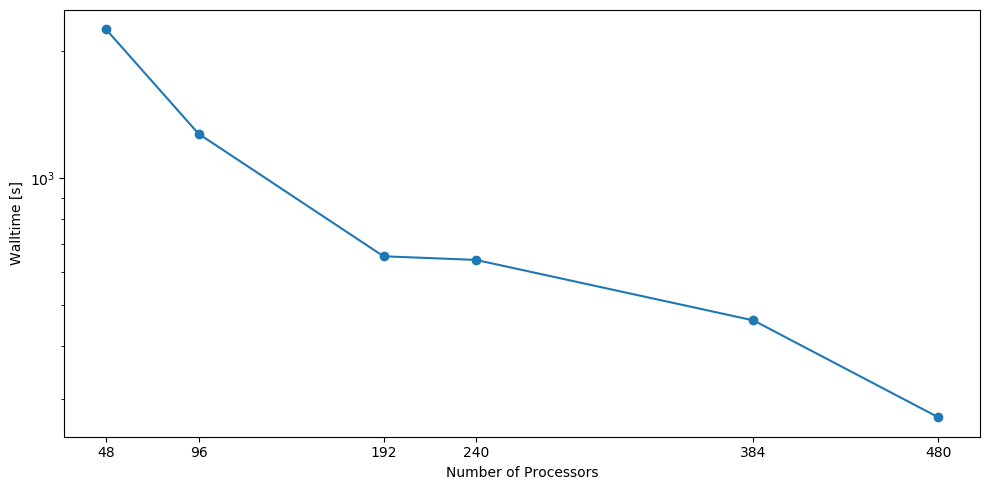

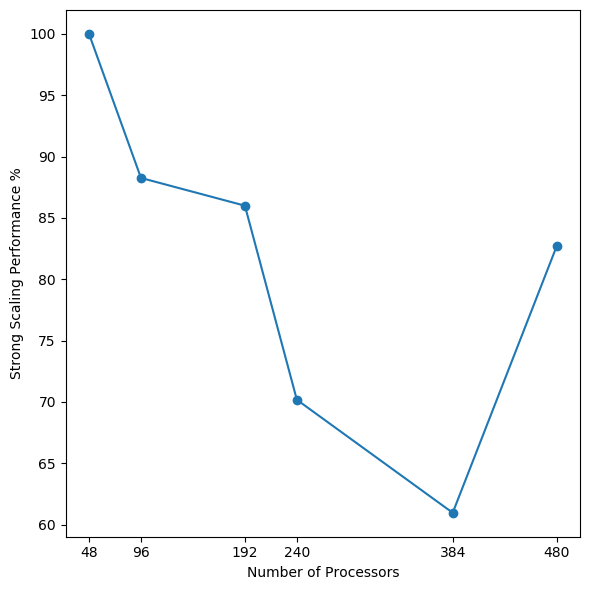

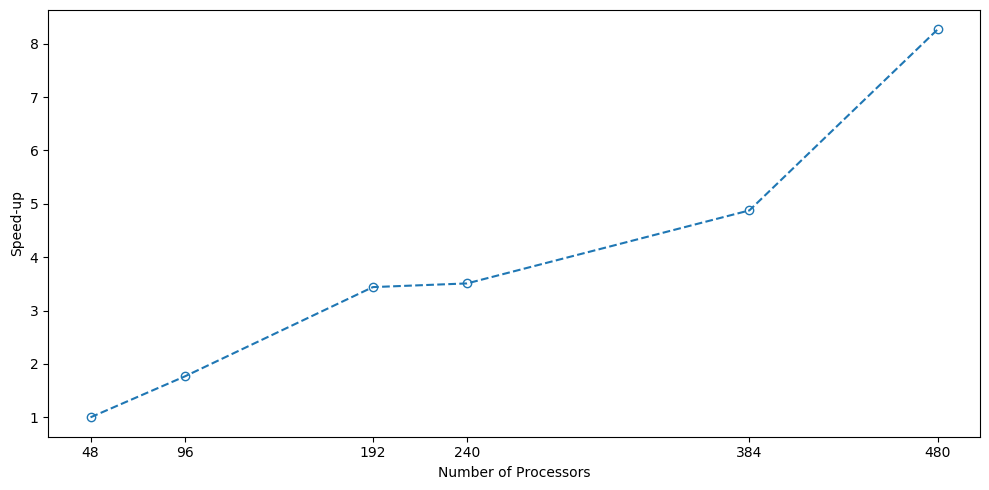

In [5]:
########################### STRONG SCALING #####################################
fig1, ax1 = plt.subplots(figsize=(10,5))

fig2, ax2 = plt.subplots(figsize=(6,6))

fig3, ax3 = plt.subplots(figsize=(10,5))


# Runtime strong scaling plot
fname='strong_scaling_perf_walltime.png'
fig1.canvas.set_window_title(fname)
ax1.plot(CORES, [ wall_time[cpu][-1] for cpu in CORES ], 
         label='strong scaling', marker='o')
ax1.set(xlabel='Number of Processors', ylabel='Walltime [s]')
ax1.set_xticks(CORES)
ax1.set_yscale('log')
# ax1.legend()
fig1.tight_layout()
# fig1.savefig(fname)
fig1.show()

# Strong scaling performance plot
fname='strong_scaling_perf.png'
fig2.canvas.set_window_title(fname)
sc = [ strong_scaling(wall_time[min(CORES)][-1], min(CORES), wall_time[cpu][-1], cpu) for cpu in CORES ]
ax2.plot(CORES, sc, label='strong scaling', marker='o')

ax2.set(xlabel='Number of Processors', ylabel='Strong Scaling Performance %')
ax2.set_xticks(CORES)
# ax2.legend()
fig2.tight_layout()
# fig2.savefig(fname)
fig2.show()

# Speedup Plot
# speedup factor = t0/tn
fname='strong_scaling_perf_speedup'
fig3.canvas.set_window_title(fname)
sf = [ wall_time[min(CORES)][-1] / wall_time[cpu][-1] for cpu in CORES ]
ax3.plot(CORES, sf, marker='o', fillstyle='none', linestyle='--')
ax3.set(xlabel='Number of Processors', ylabel='Speed-up')
ax3.set_xticks(CORES)
fig3.tight_layout()
# fig3.savefig(fname + '.png')
fig3.show()
tikz_save('/home/gn/Dropbox/PhD/Posters/ESE_2019/figures/dogleg_speedup.tikz',
            figureheight='\\figureheight',
            figurewidth='\\figurewidth')



 # NODE-HALO ratios
 ## Adapt 0

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


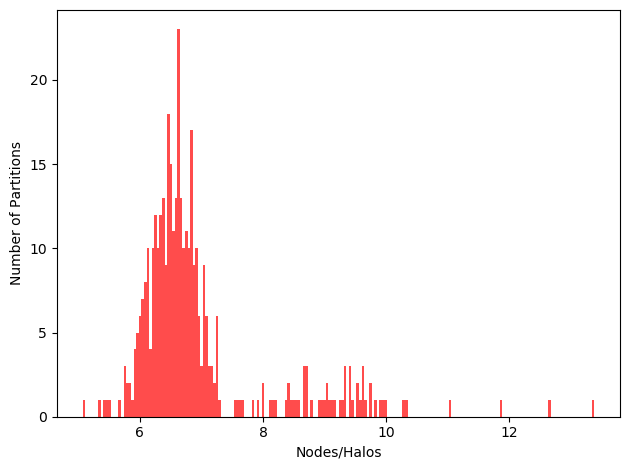

In [6]:
fig1, ax1 = plt.subplots()
fname='Node-Halo_ratio_adapt_step_0.png'
fig1.canvas.set_window_title(fname)

# Adapt step 0
# nodes = [ row[0] for row in NODES[192] ]
# halos = [ row[0] for row in HALOS[192] ]
# r = np.divide(nodes, halos)
# ax1.hist(r, 200, label='core 192', color='blue', alpha=1)


# nodes = [ row[0] for row in NODES[240] ]
# halos = [ row[0] for row in HALOS[240] ]
# r = np.divide(nodes, halos)
# ax1.hist(r, 200, label='core 240', color='blue', alpha=1)

nodes = [ row[0] for row in NODES[384] ]
halos = [ row[0] for row in HALOS[384] ]
r = np.divide(nodes, halos)
ax1.hist(r, 200, label='core 384', color='red', alpha=0.7)

# nodes = [ row[0] for row in NODES[480] ]
# halos = [ row[0] for row in HALOS[480] ]
# r = np.divide(nodes, halos)
# ax1.hist(r, 200, label='core 480', color='red', alpha=0.7)

ax1.set(xlabel='Nodes/Halos', ylabel='Number of Partitions')
# ax1.legend()
fig1.tight_layout()
# fig1.savefig(fname)
fig1.show()


 ## Adapt 5

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


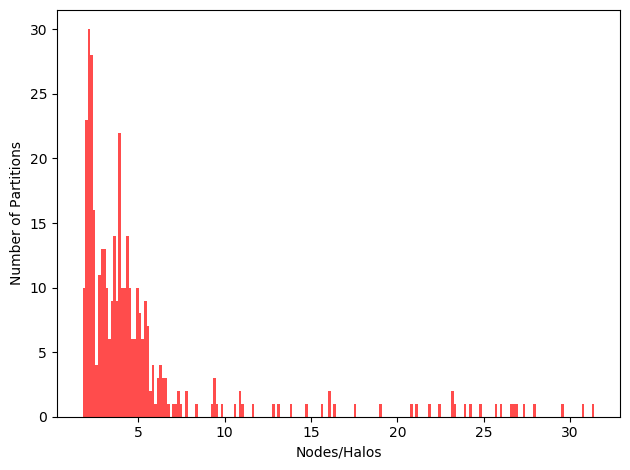

In [7]:
# Adapt step 5
fig2, ax2 = plt.subplots()
fname='Node-Halo_ratio_adapt_step_5.png'
fig2.canvas.set_window_title(fname)


# nodes = [ row[-1] for row in NODES[192] ]
# halos = [ row[-1] for row in HALOS[192] ]
# r = np.divide(nodes, halos)
# ax2.hist(r, 200, label='core 192', color='blue', alpha=1)

# nodes = [ row[-1] for row in NODES[240] ]
# halos = [ row[-1] for row in HALOS[240] ]
# r = np.divide(nodes, halos)
# ax2.hist(r, 200, label='core 240', color='blue', alpha=1)

nodes = [ row[-1] for row in NODES[384] ]
halos = [ row[-1] for row in HALOS[384] ]
r = np.divide(nodes, halos)
ax2.hist(r, 200, label='core 384', color='red', alpha=0.7)

# nodes = [ row[-1] for row in NODES[480] ]
# halos = [ row[-1] for row in HALOS[480] ]
# r = np.divide(nodes, halos)
# ax2.hist(r, 200, label='core 480', color='red', alpha=0.7)

ax2.set(xlabel='Nodes/Halos', ylabel='Number of Partitions')
# ax2.legend()
fig2.tight_layout()
# fig2.savefig(fname)
fig2.show()


 # 3D PLOTS

 ## Cores 240

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


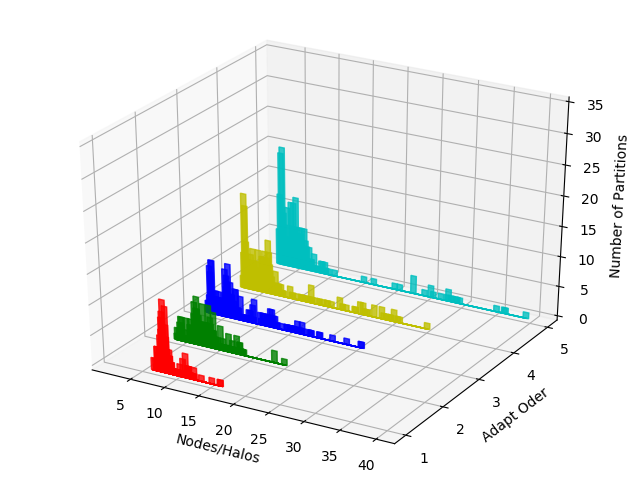

In [8]:
##################### NODE/HALOS vs ADAPT 3D
fig = plt.figure(figsize=(8, 6))
fname='Node-Halo_ratio_3D_core240.png'
fig.canvas.set_window_title(fname)

ax = fig.add_subplot(111, projection='3d')
nbins = 200
for c, z, col in zip(['r', 'g', 'b', 'y', 'c'], [1, 2, 3, 4, 5], range(len(NODES[240][0]))):

    nodes = [row[col] for row in NODES[240]]
    halos = [row[col] for row in HALOS[240]]
    ys = np.divide(nodes, halos)

    hist, bins = np.histogram(ys, bins=nbins)
    xs = (bins[:-1] + bins[1:])/2

    ax.bar(xs, hist, zs=z, zdir='y', color=c, ec=c, alpha=0.8)

ax.set_yticks([1, 2, 3, 4, 5])
ax.set_zlim3d(0, 35)
ax.set_zticks(range(0, 40, 5))
ax.set_xlabel('Nodes/Halos')
ax.set_ylabel('Adapt Oder')
ax.set_zlabel('Number of Partitions')
# fig.savefig(fname)
fig.show()


 ## Cores 384

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


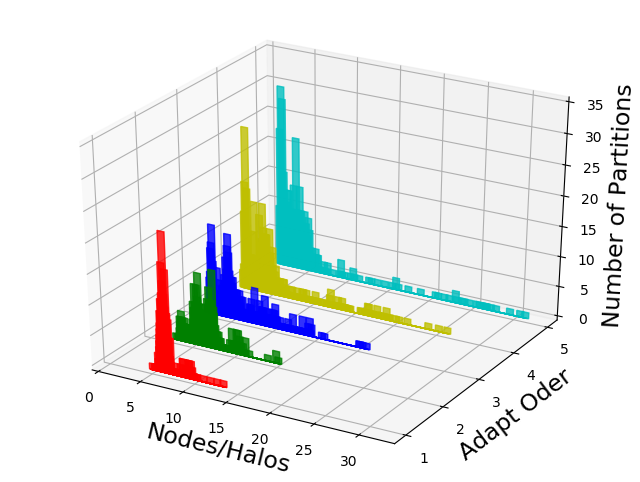

In [9]:
##################### NODE/HALOS vs ADAPT 3D
fig = plt.figure(figsize=(8, 6))
fname='Node-Halo_ratio_3D_core384.png'
fig.canvas.set_window_title(fname)

ax = fig.add_subplot(111, projection='3d')
nbins = 200
for c, z, col in zip(['r', 'g', 'b', 'y', 'c'], [1, 2, 3, 4, 5], range(len(NODES[384][0]))):

    nodes = [row[col] for row in NODES[384]]
    halos = [row[col] for row in HALOS[384]]
    ys = np.divide(nodes, halos)

    hist, bins = np.histogram(ys, bins=nbins)
    xs = (bins[:-1] + bins[1:])/2

    ax.bar(xs, hist, zs=z, zdir='y', color=c, ec=c, alpha=0.8)

ax.set_yticks([1, 2, 3, 4, 5])
ax.set_zlim3d(0, 35)
ax.set_zticks(range(0, 40, 5))
ax.set_xlabel('Nodes/Halos', fontsize=17)
ax.set_ylabel('Adapt Oder', fontsize=17)
ax.set_zlabel('Number of Partitions', fontsize=17)
# fig.savefig(fname)
fig.show()

 ## Cores 480

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


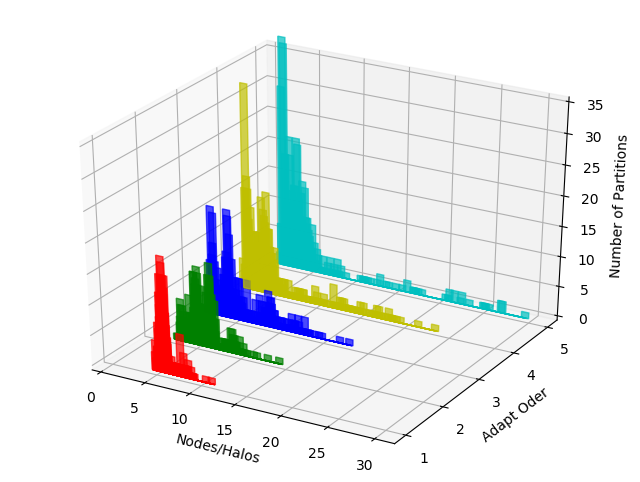

In [10]:
# todo: this breaks the js backend, submit bug report to developers' team.
# %matplotlib notebook
fig = plt.figure(figsize=(8, 6))
fname='Node-Halo_ratio_3D_core480.png'
fig.canvas.set_window_title(fname)

ax = fig.add_subplot(111, projection='3d')
nbins = 200
for c, z, col in zip(['r', 'g', 'b', 'y', 'c'], [1, 2, 3, 4, 5], range(len(NODES[480][0]))):

    nodes = [row[col] for row in NODES[480]]
    halos = [row[col] for row in HALOS[480]]
    ys = np.divide(nodes, halos)

    hist, bins = np.histogram(ys, bins=nbins)
    xs = (bins[:-1] + bins[1:])/2

    ax.bar(xs, hist, zs=z, zdir='y', color=c, ec=c, alpha=0.7)

ax.set_yticks([1, 2, 3, 4, 5])
ax.set_zlim3d(0, 35)
ax.set_zticks(range(0, 40, 5))
ax.set_xlabel('Nodes/Halos')
ax.set_ylabel('Adapt Oder')
ax.set_zlabel('Number of Partitions')
# fig.savefig(fname)
fig.show()

